In [1]:
import copy
import csv
import os
import time
from typing import Callable
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from tqdm import tqdm
from torchvision import transforms
from _types import CLASS_COUNT
import glob
from PIL import Image

from CamVidData import  mask_to_rgb, compare_images
import pandas as pd
import matplotlib.pyplot as plt

from segmentationData import SegmentationDataset

In [2]:
transformations = transforms.Compose(
                              [
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            ]
                            )




dataset = SegmentationDataset(Path("data/CamVid"),
                              transforms=transformations,
                              image_folder="test",
                              mask_folder="test_labels",
                              augments=list())

dataloader = DataLoader(
            dataset=dataset,
            batch_size=1,
            shuffle=False)

classlabels = pd.read_csv(Path("data/CamVid") / "class_dict.csv")

In [3]:
model_paths = sorted(Path("out/").glob("*.pt"))

# Evaluation

## Max use this one to calculate the scores

In [4]:
device = torch.device("cpu")
mask_paths = sorted((Path("data/CamVid")/ "test_labels").glob("*"))
prediction_folder = Path("out/predictions")

for model_path in model_paths:

    model = torch.load(model_path, map_location=device)

    model.eval()

    for index, input_batch in tqdm(enumerate(iter(dataloader))):
        target_mask = input_batch["mask"]

        with torch.no_grad():
            output = model(input_batch["image"])['out'][0]
        output_predictions = output.argmax(0)


        # Put evaluation here

[PosixPath('out/deeplabv3_all_weights.pt'),
 PosixPath('out/deeplabv3_crop_weights.pt'),
 PosixPath('out/deeplabv3_flip_weights.pt'),
 PosixPath('out/deeplabv3_jitter_weights.pt'),
 PosixPath('out/deeplabv3_no_transforms_weights.pt'),
 PosixPath('out/deeplabv3_perspective_weights.pt')]

# Mask prediction image generation

In [5]:
device = torch.device("cpu")

model = torch.load("out/deeplabv3_jitter_weights.pt", map_location=device)

model.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [6]:
mask_paths = sorted((Path("data/CamVid")/ "test_labels").glob("*"))
prediction_folder = Path("out/predictions")

In [7]:
for index, input_batch in tqdm(enumerate(iter(dataloader))):
    with torch.no_grad():
        output = model(input_batch["image"])['out'][0]
    output_predictions = output.argmax(0)

    mask_name = os.path.basename(mask_paths[index])
    prediction_mask = mask_to_rgb(output_predictions.numpy(),class_labels=classlabels)

    Image.fromarray(prediction_mask).save(prediction_folder / ("jitter/" + mask_name))


171it [12:08,  4.18s/it]

In [13]:
sample = dataset[100]
input_batch = sample["image"].unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
#if torch.cuda.is_available():
#    input_batch = input_batch.to('cuda')
#    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]


output_predictions = output.argmax(0)

y = mask_to_rgb(output_predictions.numpy(),classlabels)

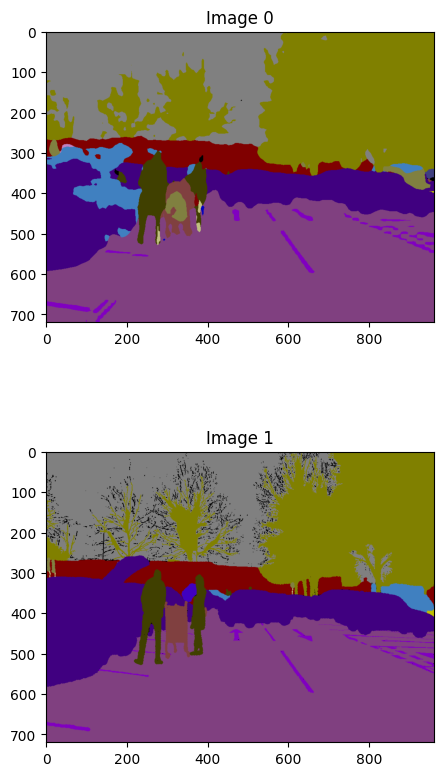

In [16]:
compare_images([y,mask_to_rgb(sample["mask"].numpy(),classlabels)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


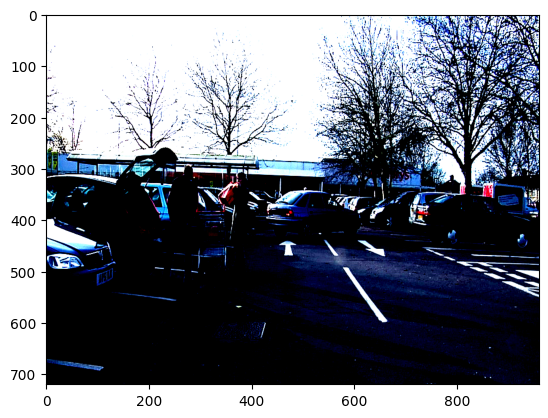

In [14]:
plt.imshow(sample["image"].permute(1,2,0).numpy())

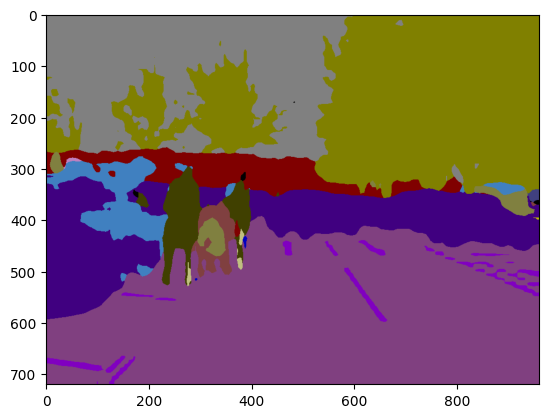

In [15]:
plt.imshow(y)